<h1 style="text-align:center; font-size: 50px; margin: 0; font-weight: 300; margin-bottom: 5px">Exoplanets Homework 3 - Tom Wagg</h1>
<h3 style="text-align:center; font-size: 25px; font-style: italic; font-weight: 100; margin: 0; margin-bottom: 10px">It's TTV Time</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

import rebound

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Contents
- [Problem 1](#p1)
- [Problem 2](#p2)
<!-- - [Problem 3](#p3)
- [Problem 4](#p4) -->

<h1><a id="p1">Problem 1</a></h1>

*Install the dynamical integrator REBOUND using Python:https://rebound.readthedocs.io/en/latest/. Look through the examplenotebooks, and familiarize yourself with initializing and running a planetary system. [2 pt]*

<hr>

In [3]:
rebound.__version__

'3.19.3'

Okay rebound is installed, let's run a test simulation

In [4]:
sim = rebound.Simulation()

sim.add(m=1.)                # Central object
sim.add(m=1e-3, a=1., e=0.1) # Jupiter mass planet 
sim.add(a=1.4, e=0.1)        # Massless test particle

sim.integrate(100.)

for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.calculate_orbits(): 
    print(o)

0.0001379031111733169 0.11100285684422287 0.0
0.7620968888266642 -0.3934338982350228 0.0
-1.5948501191422428 0.20487096187200812 0.0
<rebound.Orbit instance, a=0.9999999999999998 e=0.10000000000000006 inc=0.0 Omega=0.0 omega=0.0 f=5.698402270529936>
<rebound.Orbit instance, a=1.4174273398342736 e=0.12988282793113465 inc=0.0 Omega=0.0 omega=0.09938842199489617 f=2.9831333920230048>


<h1><a id="p2">Problem 2</a></h1>

*Look up the parameters of the planet system Kepler-289c/d (aka Planethunters 3; ignore planet b). Assume the planets’ orbits lie in a plane,and vary the inclination of the system (so that it would not transit). At what inclination does the system become unstable after 1000 orbits of the inner planet? What upper limit would this place on the planets’ masses if they were measured with RV rather than TTV?*

<hr>

We can find the data for Kepler-289 here: http://www.openexoplanetcatalogue.com/planet/Kepler-289%20c/

In [51]:
kepler289star = {
    "mass": 1.08 * u.Msun,
    "radius": 1.00 * u.Rsun
}

kepler289d = {
    "mass": 0.013 * u.Mjup,
    "radius": 0.239 * u.Rjup,
    "a": 0.33 * u.AU
}

kepler289c = {
    "mass": 0.41 * u.Mjup,
    "radius": 1.034 * u.Rjup,
    "a": 0.51 * u.AU
}

kepler289_system = [kepler289star, kepler289d, kepler289c]

In [52]:
innermost_period = (2 * np.pi * np.sqrt(kepler289d["a"]**3 / (const.G * kepler289star["mass"]))).to(u.yr).value

In [74]:
outer_period = (2 * np.pi * np.sqrt(kepler289c["a"]**3 / (const.G * kepler289star["mass"]))).to(u.yr).value

In [75]:
outer_period / innermost_period

1.9212520961158253

In [86]:
rvs_both = None
rvs_c = None
rvs_d = None

<rebound.Orbit instance, a=0.33 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=0.2982447085926244 e=0.24285589103013785 inc=0.0 Omega=0.0 omega=0.27054706669901396 f=5.912403014810375>


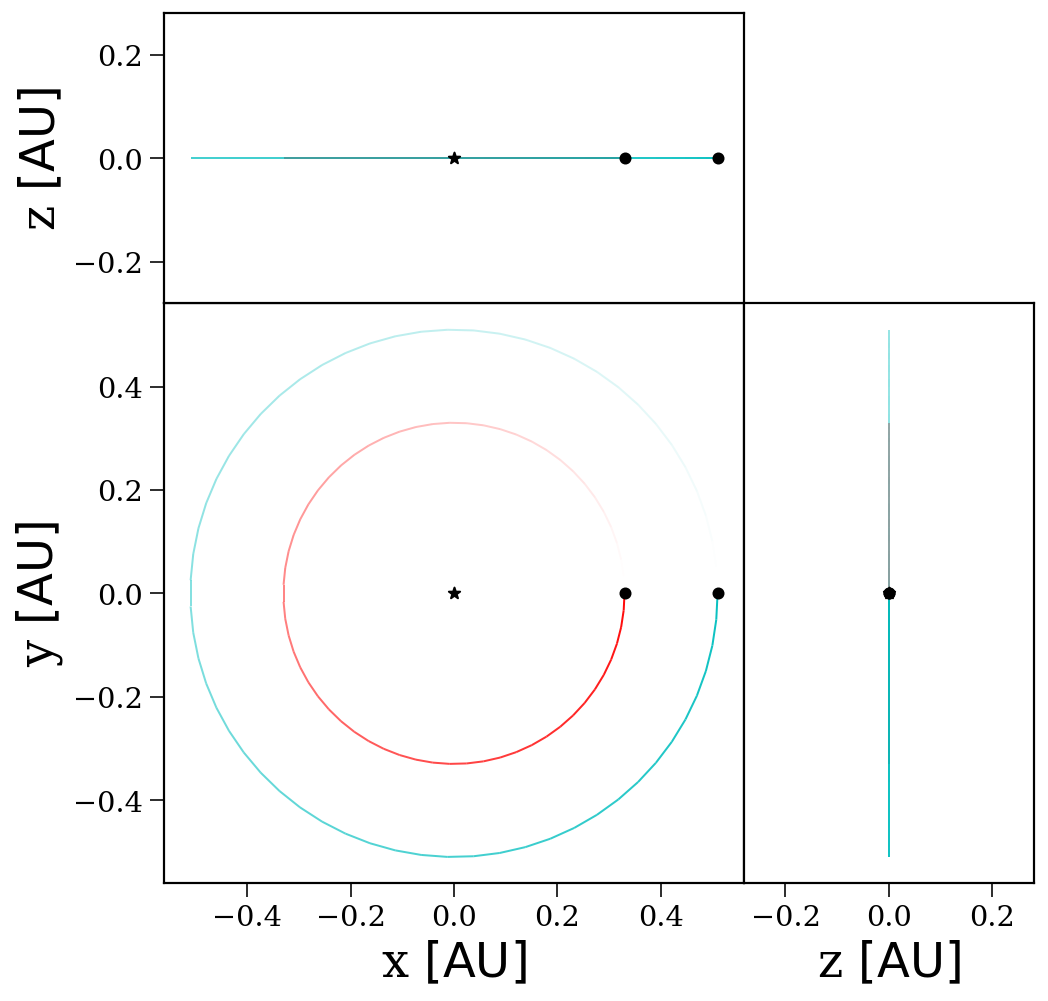

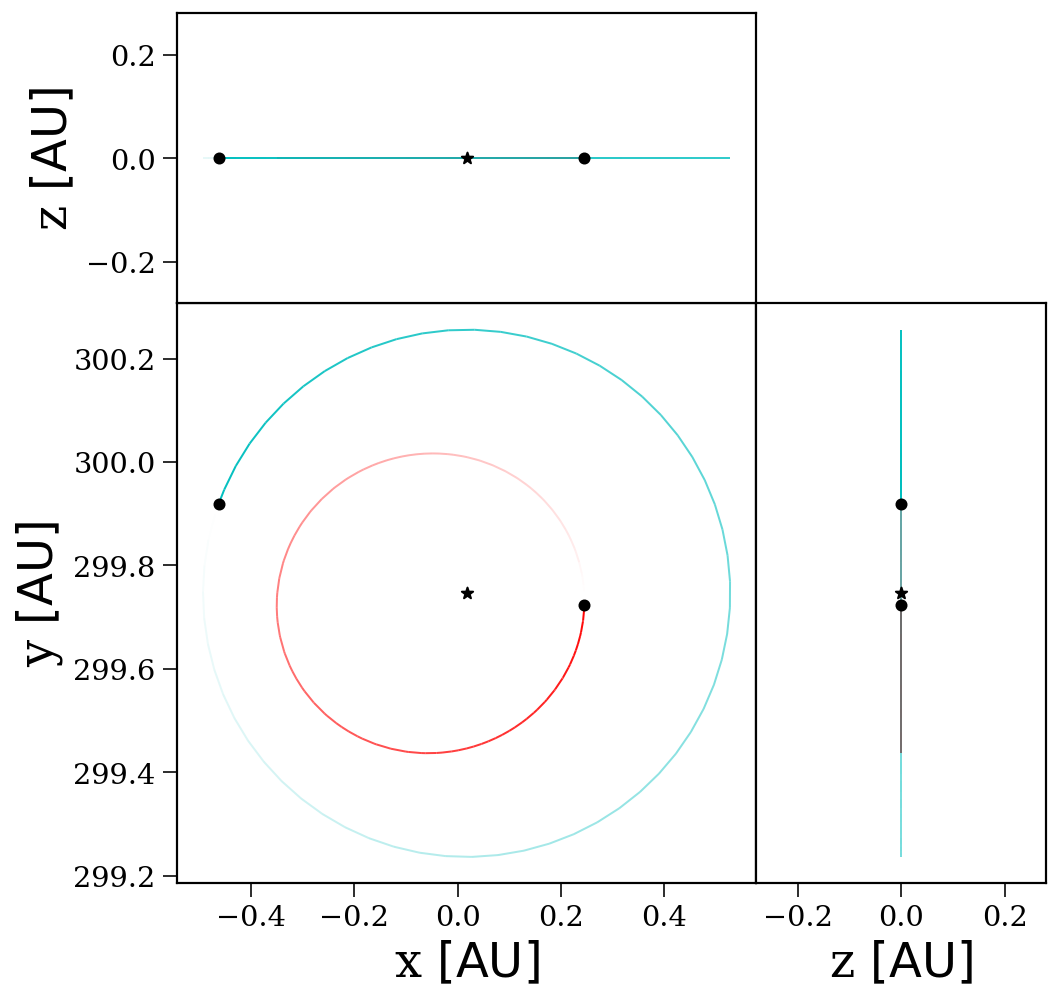

In [122]:
# settings
fancy = False
color = True

# start simulation, adjust units
sim = rebound.Simulation()
sim.units = ("yr", "AU", "Msun")

# set inclination and calculate innermost planet's period
inc = 0

sim.add(m=kepler289star["mass"].to(u.Msun).value, r=kepler289star["radius"].to(u.AU).value)
sim.add(m=kepler289d["mass"].to(u.Msun).value, r=kepler289d["radius"].to(u.AU).value, a=kepler289d["a"].to(u.AU).value, inc=inc)
sim.add(m=kepler289c["mass"].to(u.Msun).value * 50, r=kepler289c["radius"].to(u.AU).value, a=kepler289c["a"].to(u.AU).value, inc=inc)
        
# create plots of the orbits before and after integrating 1000x period of innermost planet
fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=color, fancy=fancy, slices=0.5)

print(sim.calculate_orbits()[0])

n_steps = 10000
max_time = 1000 * innermost_period
timesteps = np.linspace(0, max_time, n_steps)

rvs = np.zeros(n_steps)
for i, t in enumerate(timesteps):
    sim.integrate(t)
    rvs[i] = sim.particles[0].vx
# sim.integrate(1000 * innermost_period)

fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=color, fancy=fancy, slices=0.5)

print(sim.calculate_orbits()[0])

plt.show()

In [63]:
(u.AU / u.yr).to(u.m/u.s)

4740.470463533348

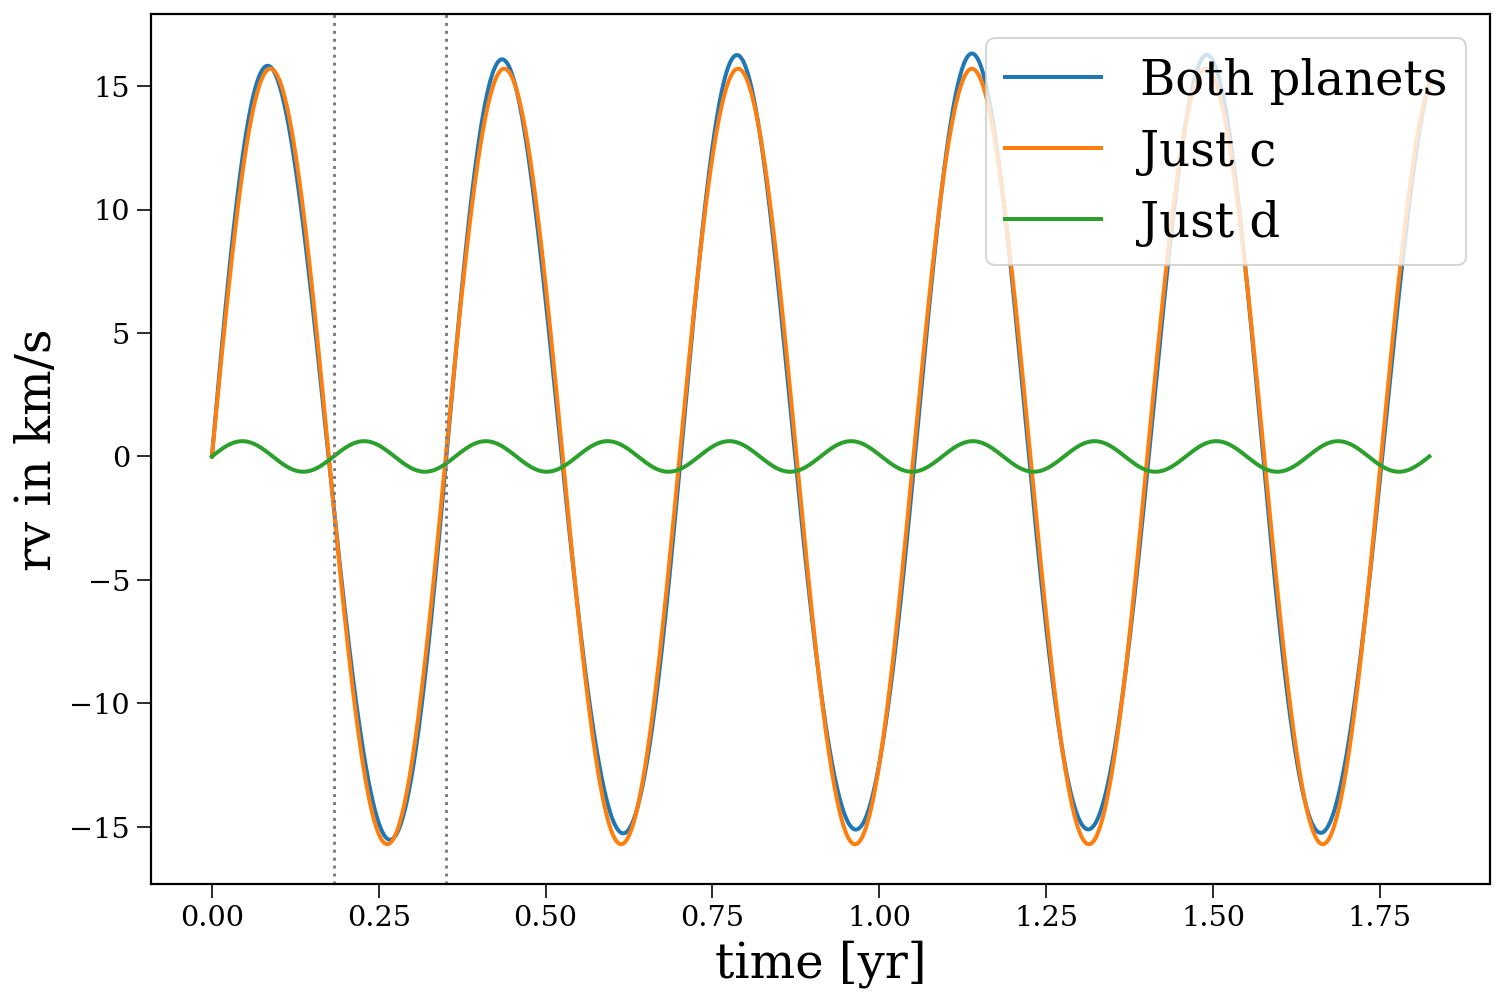

In [102]:
lim = 10000
lw = 2

plt.plot(timesteps[:lim], rvs_both[:lim] * 4740.47, lw=lw, label="Both planets")
plt.plot(timesteps[:lim], rvs_c[:lim] * 4740.47, lw=lw, label="Just c")
plt.plot(timesteps[:lim], rvs_d[:lim] * 4740.47, lw=lw, label="Just d")
plt.ylabel("rv in km/s")

plt.legend()

for period in [innermost_period, outer_period]:
    plt.axvline(period, linestyle="dotted", color="grey")


plt.xlabel("time [yr]")

plt.show()

In [64]:
kstar = (0.5 * (rvs.max() - rvs.min()) * u.AU / u.yr).to(u.m/u.s)

In [106]:
def get_Mp_sini(kstar, P, Ms, e=0):
    return (kstar / (2 * np.pi * const.G / (P * (1 - e**2)))**(1/3) * Ms**(2/3)).to(u.Mjup)

In [107]:
get_Mp_sini(kstar, outer_period * u.yr, kepler289star["mass"])

<Quantity 0.4257865 jupiterMass>

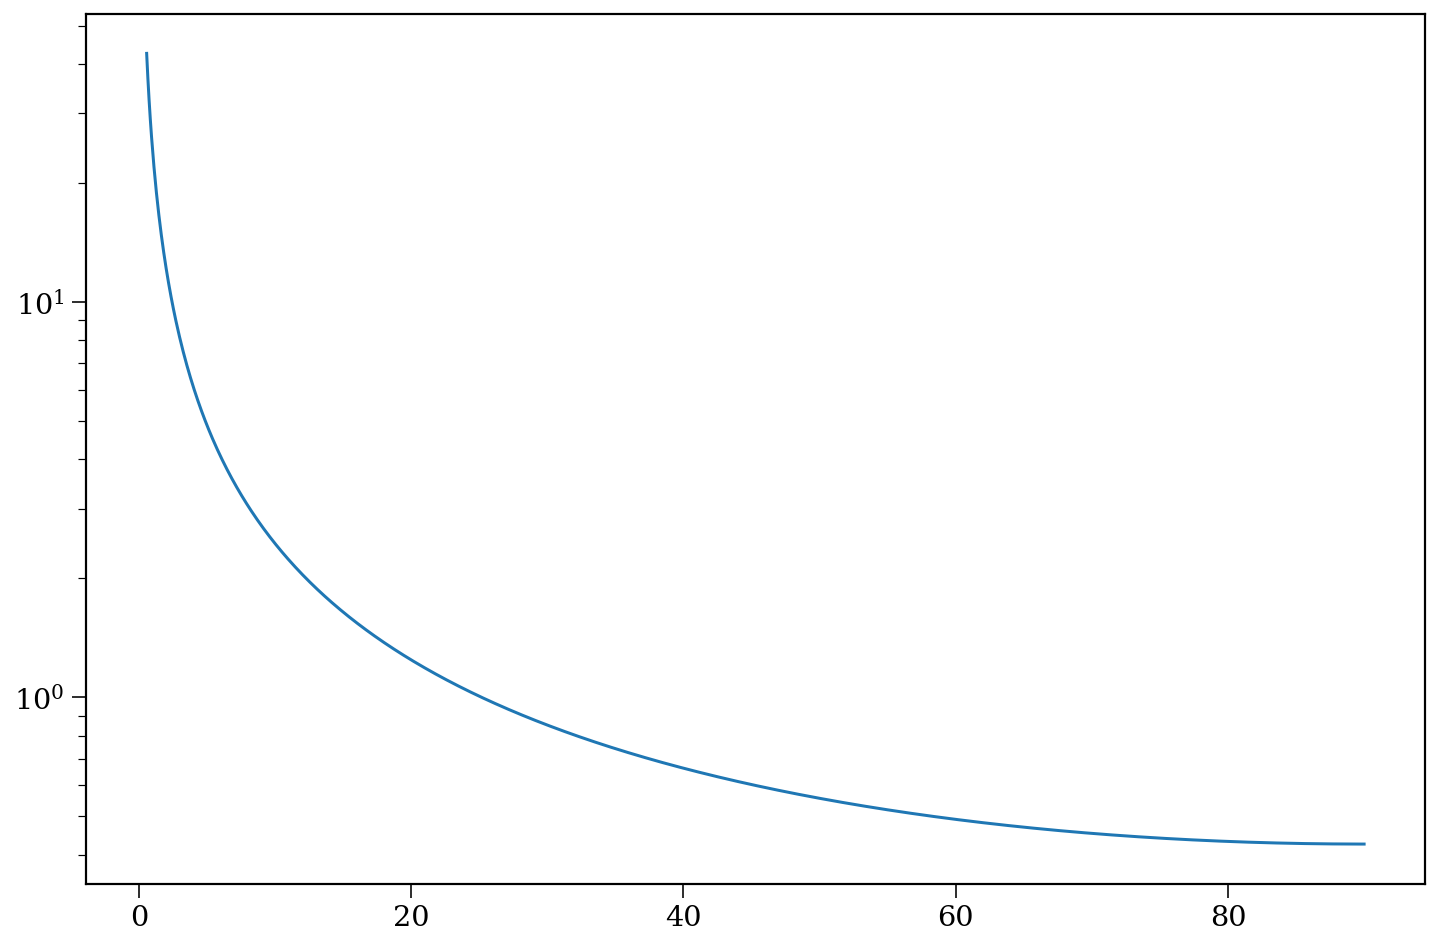

In [124]:
i_range = np.linspace(0.01, np.pi / 2, 1000)

plt.plot(i_range / (np.pi / 2) * 90, get_Mp_sini(kstar, outer_period * u.yr, kepler289star["mass"]) / np.sin(i_range))

plt.yscale("log")

plt.show()

<h1><a id="p3">Problem 3</a></h1>

*Simulate the edge-on radial velocity of the star, and then fit this RV with four Keplerian orbits. How big are the residuals? How does this compare to typical RV errors?*

<hr>

[RV Example in REBOUND](https://rebound.readthedocs.io/en/latest/ipython_examples/RadialVelocity/)

<h1><a id="p4">Problem 4</a></h1>

*Look at [REBOUND TTV example](https://rebound.readthedocs.io/en/latest/ipython_examples/TransitTimingVariations/). Make a plot of the TTVs of Kepler-289c/d over 4 years (assuming edge-on, so that planets do in fact tran-sit). Measure amplitude and period of the sinusoidal variation compo-nent. How does it change if you vary the mass of Kepler-289d downwardand upward by a factor of 2?*

<hr>

In [133]:
# start simulation, adjust units
sim = rebound.Simulation()
sim.units = ("yr", "AU", "Msun")

sim.add(m=kepler289star["mass"].to(u.Msun).value, r=kepler289star["radius"].to(u.AU).value)
sim.add(m=kepler289d["mass"].to(u.Msun).value, r=kepler289d["radius"].to(u.AU).value, a=kepler289d["a"].to(u.AU).value)
sim.add(m=kepler289c["mass"].to(u.Msun).value * 50, r=kepler289c["radius"].to(u.AU).value, a=kepler289c["a"].to(u.AU).value)

N=1000
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i < N:
    y_old = p[1].y - p[0].y
    t_old = sim.t
    sim.integrate(sim.t + innermost_period / 100) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t + innermost_period / 1000)       # integrate 0.05 to be past the transit

In [134]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]

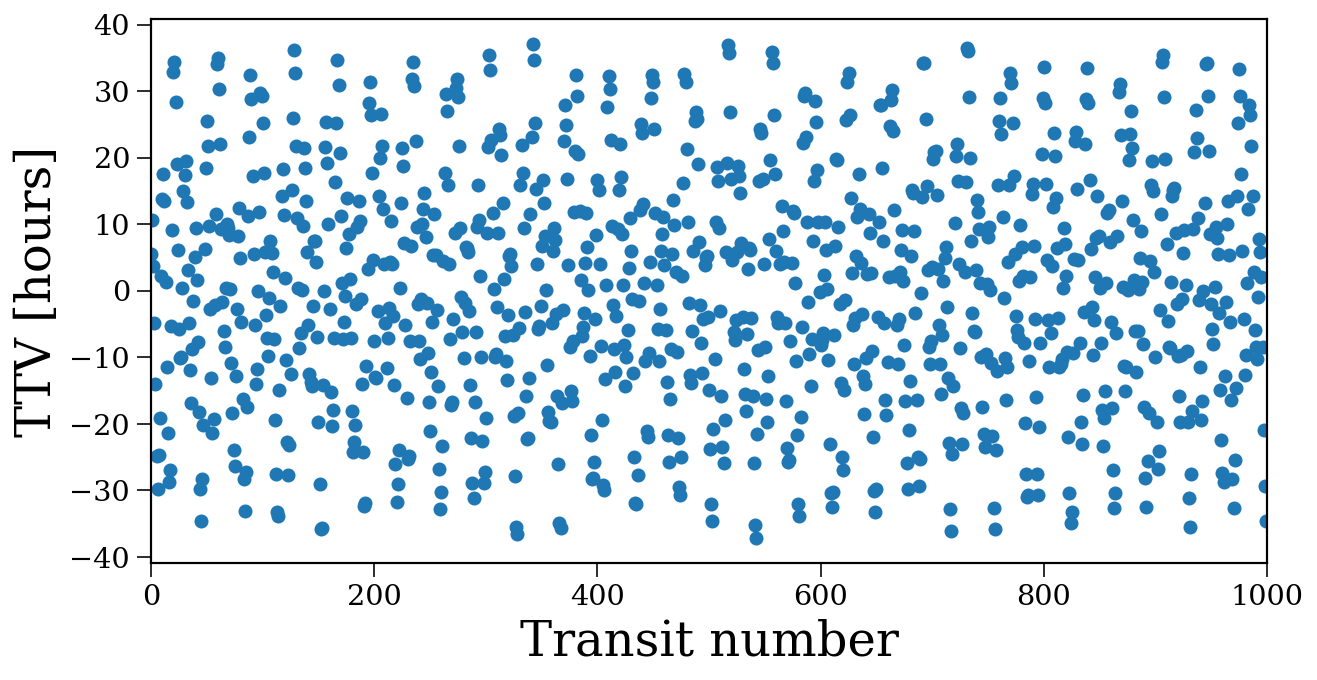

In [135]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));
